## 4.7 LGBM 


#### LGBM은 XGBOOST보다 빠른 속도이지만 비슷한 성능
#### 데이터의 갯수가 적을 경우 과적합이 발생하기 쉽다.
#### 적은 데이터의 갯수에 대한 기준은 애매하지만 LightGBM의 공식 문서에서 10,000건 이하

##### -균형 트리 분할: 최대한 균형 잡힌 트리를 유지하며 분할하기에 트리의 깊이가 최소화됨 -> 오버피팅에 강한 구조. 하지만 오랜 시간 걸림
##### -리프 중심 트리 분할: 트리 균형을 맞추지 않고, 최대손실값을 가지는 리프 노드를 지속적 분할 -> 트리가 깊고 비대칭적 -> 그러나 이게 반복되면 예측 오류 손실을 최소화함 (LGBM 구현 원리) 

#### **주요파라미터**
##### -n_estimators [default: 100]: GBM과 XGB의 n_estimators와 같은 파라미터

-learning_rate [defalut: 0.1]: GBM과 XGB의 학습률(learning_rate)과 같은 파라미터, 일반적으로 n_estimators를 높이고 learning_rate를 낮추면 예측 성능이 향상하지만 마찬가지로 과적합 이슈 및 소요 시간 증가의 문제가 있다.

-max_depth [default: 1]: 트리 기반 알고리즘의 max_depth와 같다. 0보다 작은 값을 지정하면 깊이 제한이 없다. LightGBM은 Leaf Wise 방식이므로 깊이가 상대적으로 더 깊다.

-min_child_samples [default: 20]: 결정 트리의 min_samples_leaf와 같은 파라미터로 리프 노드가 되기 위해 최소한으로 필요한 샘플 수

-num_leaves [default: 31]: 하나의 트리가 가질 수 있는 최대 리프 개수

-boosting [default: gbdt]: 부스팅의 트리를 생성하는 알고리즘을 지정하며 gbdt는 일반적인 그래디언트 부스팅 결정 트리이며 rf는 랜덤 포레스트이다.

-subsample [default: 1]: GBM과 XGB의 subsample과 같은 파라미터

-colsample_bytree [default: 1]: XGB의 colsample_bytree와 같은 파라미터로 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율

-reg_lambda [default: 0]: XGB의 reg_lambda와 같은 파라미터로 L2 regulation 제어를 위한 값이다. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다.

-reg_alpha [default: 0]: XGB의 reg_alpha와 같은 파라미터로 L1 regulation 제어를 위한 값이다. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다.

#### *사이킷런 래퍼 LGBM의 파라미터로 파이썬 래퍼와 비교하는건 P-250에 있음*

In [ ]:
import lightgbm

print(lightgbm.__version__)

2.2.3


### **LGBM 실습**

In [ ]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True) #조기중단: early_stopping_rounds
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248	valid_1's binary_logloss: 0.628248
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_logloss: 0.588173	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	training's binary_loglos

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
#예측 성능 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9888


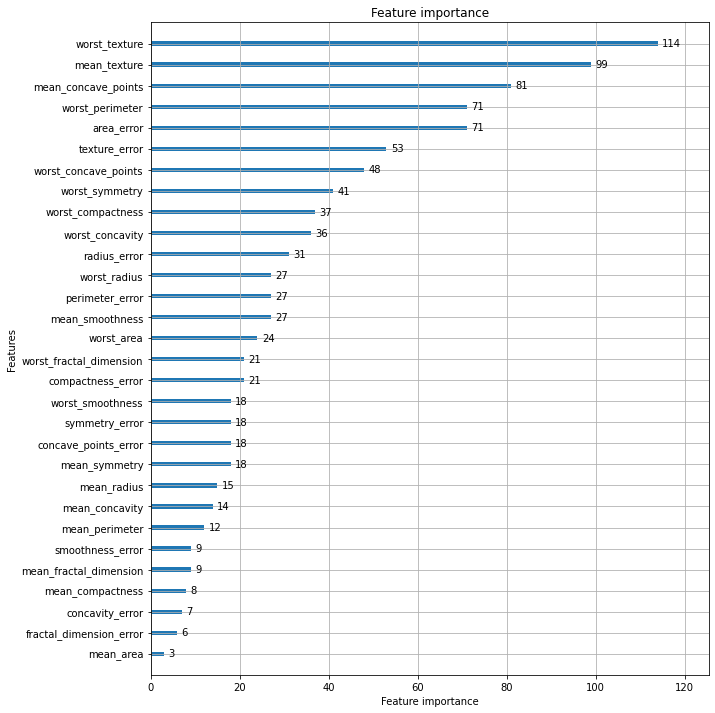

In [ ]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

## **4-8 베이지안 최적화 기반 하이퍼 파라미터 튜닝**
#### 그리드서치: 파라미터많을 때 오래걸림 -> 베이지안 최적화 기법 사용
#### 그리드처럼 여러번 반복해서 목적함수를 찾는 것이 아닌, 베이지안 확률에 기반을 둠
#### 즉, 새로운 데이터를 받았을 때 최적함수를 예측하는 사후 확률을 개선

##### -대체모델(surrogate model): 획득함수로부터 최적함수를 예측할 수 있는 입력값을 추천받아 이를 기반으로 최적함수 모델을 개선 
##### -획득함수(acquisition function): 개선된 매체 모델을 기반으로 최적입력값을 계산

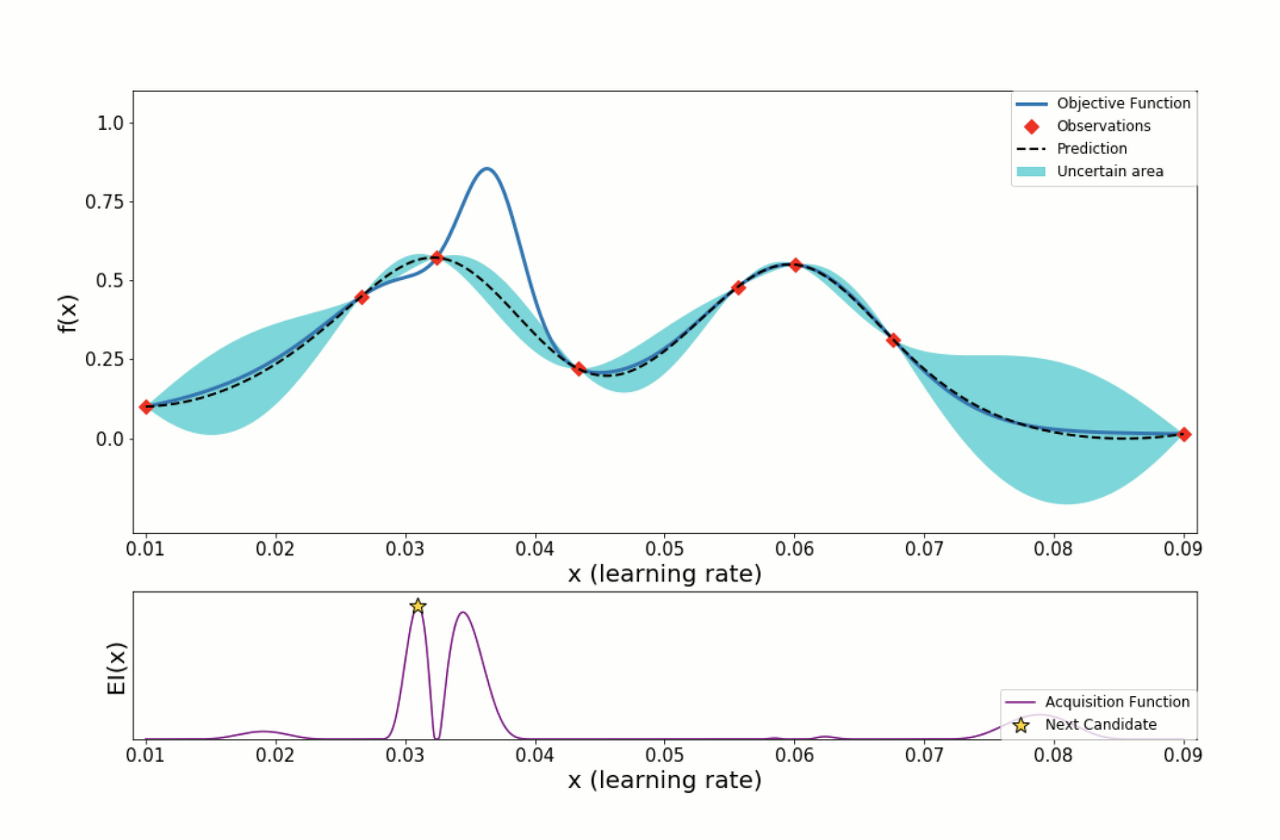

##### 위의 파란색 선은, 우리가 찾으려고 하는 목적함수 f(x) 를 나타내고,
##### 검정색 점선은, 지금까지 관측한 데이터를 바탕으로 우리가 예측한 estimated function 을 의미합니다.
##### 검정색 점선 주변에 있는 파란 영역은, 목적함수 f(x) 가 존재할만한 confidence bound(function의 variance) 를 의미합니다.
##### 밑에 있는 EI(x) 는, Acquisition function 을 의미하며, 다음 입력값 후보 추천 시 사용됩니다.
##### Acquisition function(획득함수) 값이 컸던 지점을 확인하고, 해당 지점의 hyperparameter 를 다음 입력 값으로 사용합니다.
##### hyperparamter 에 따라 estimated function 을 계속 update 하면, estimation function 과 목적 함수 f(x) 가 흡사해집니다.
##### 관측한 지점 중 best point 을 argmax f(x) 로 선택합니다.


### **HyperOpt 실습** (안되서 주피터에 썼음)
##### HyperOpt는 다음과 같은 프로세스를 통해 사용할 수 있다.

##### 1. 검색 공간 설정
##### 2. 목적 함수 절정
##### 3. fmin() 함수를 통해 베이지안 최적화 기법에 기반한 최적의 입력 값 찾기

In [ ]:
pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from hyperopt import hp

In [2]:
# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정.
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }
# 입력변수명, 입력값 검색 공간은 딕셔너리 형태, 키값으로 입력변수명:밸류값으로 입력 변수 검색 공간 주어짐
# hp.quniforn(label,low,high,q) -> 라벨, 최소,최대,간격

In [3]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

#### fmin()함수는 목적함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법에 기반해 찾아주는 함수

In [4]:
from hyperopt import fmin, tpe, Trials
import numpy as np

## 입력 결과를 저장할 객체 생성
trial_val = Trials()

## 목적 함수의 최솟값을 반환하는 최적 입력 변수를 5번 시도로 찾아냄
## fmin() 함수는 아래의 주요 인자를 가짐
best_01 = fmin(fn=objective_func,    ## 목적 함수
               space=search_space,   ## 검색 공간
               algo=tpe.suggest,     ## 베이지안 최적화 적용 알고리즘
               max_evals=5,         ## 입력 시도 횟수
               trials=trial_val,     ## 시도한 입력 값 및 입력 결과 저장
               rstate=np.random.default_rng(seed=0)   ## fmin()을 시도할 때마다 동일한 결과를 가질 수 있도록 설정하는 랜덤 시드
               )

print('best:', best_01)

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]


AttributeError: ignored

In [ ]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func,    ## 목적 함수
               space=search_space,   ## 검색 공간
               algo=tpe.suggest,     ## 베이지안 최적화 적용 알고리즘 (기본 파라미터 tpe.suggest)
               max_evals=20,         ## 입력 시도 횟수
               trials=trial_val,     ## 시도한 입력 값 및 입력 결과 저장
               #rstate=np.random.default_rng(seed=0)   ## fmin()을 시도할 때마다 동일한 결과를 가질 수 있도록 설정하는 랜덤 시드
               )
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 390.64it/s, best loss: -236.0]
best: {'x': -2.0, 'y': 12.0}


In [ ]:
#fmin()에 인자로 들어가는 trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
#리스트 내부의 개별 원소는 {'loss':함수반환값,'status':반환 상태값} 형태의 딕셔너리

print(trial_val.results)

[{'loss': 176.0, 'status': 'ok'}, {'loss': -196.0, 'status': 'ok'}, {'loss': 189.0, 'status': 'ok'}, {'loss': 289.0, 'status': 'ok'}, {'loss': 145.0, 'status': 'ok'}, {'loss': 249.0, 'status': 'ok'}, {'loss': 276.0, 'status': 'ok'}, {'loss': -156.0, 'status': 'ok'}, {'loss': 4.0, 'status': 'ok'}, {'loss': 280.0, 'status': 'ok'}, {'loss': 105.0, 'status': 'ok'}, {'loss': -204.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -236.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 301.0, 'status': 'ok'}, {'loss': 316.0, 'status': 'ok'}, {'loss': -140.0, 'status': 'ok'}, {'loss': -91.0, 'status': 'ok'}, {'loss': 49.0, 'status': 'ok'}]


In [ ]:
print(trial_val.vals)

{'x': [6.0, -2.0, -3.0, 3.0, 5.0, -3.0, 6.0, 8.0, -8.0, 0.0, 5.0, -6.0, -4.0, -2.0, 2.0, -9.0, -4.0, -10.0, 7.0, 7.0], 'y': [-7.0, 10.0, -9.0, -14.0, -6.0, -12.0, -12.0, 11.0, 3.0, -14.0, -4.0, 12.0, -2.0, 12.0, -3.0, -11.0, -15.0, 12.0, 7.0, 0.0]}


#### 해석: max_evals=n개로 fmin() 함수는 20번 반복 수행했으므로 20개의 반환값들로 구성된 리스트 하달

In [ ]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 
                          'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,6.0,-7.0,176.0
1,-2.0,10.0,-196.0
2,-3.0,-9.0,189.0
3,3.0,-14.0,289.0
4,5.0,-6.0,145.0
5,-3.0,-12.0,249.0
6,6.0,-12.0,276.0
7,8.0,11.0,-156.0
8,-8.0,3.0,4.0
9,0.0,-14.0,280.0


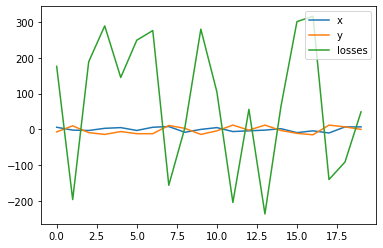

In [ ]:
result_df.plot()

### **-HyperOpt를 이용한 xgboost 하이퍼 파라미터 최적화**

#### 주의사항
#### 1. 특정 하이퍼 파라미터들은 정숫값만 입력받아야하는데 hyperopt는 입력값, 반환값 모두 실수형이라 type 변환 필요
#### 2. 최댓값을 최적화 하는 경우엔 -1곱해줘야 함

In [ ]:
# 아래 코드는 이전에 수록된 코드라 책에는 싣지 않았습니다. 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

##### 1. 검색공간 설정

In [ ]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로 (quniform)
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색. (uniform)
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), ## 정수형 하이퍼 파라미터 => quniform 사용
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1), ## 정수형 하이퍼 파라미터 => quniform 사용
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

##### 2. 목적함수 설정

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

####  fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
#### XGBClassifier의 정수형 하이퍼 파라미터는 **정수형 변환을 해줘야 함.**
#### 따라서 하이퍼파라미터가 받는 숫자가 정수형인지, 실수형인지 살펴볼 것
#### **정확도는 높을수록 더 좋은 수치임. -1x정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환**

In [ ]:
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']), #int붙이기
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3) #교차검증표 함수 사용
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK} #-1곱하기,

##### 3. fmin()함수를 이용해 최적화 함수 찾기

In [ ]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func, #목적함수
            space=xgb_search_space, #하이퍼파라미터 검생공간
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, #rstate=np.random.default_rng(seed=0)
            )
print('best:', best)

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]


AttributeError: ignored

#### 정수형 파라미터인 max_depth, min_child_weight가 실수형으로 도출됨 -> 앞에서 말한 int붙인건 3.2313 이런값 안나오게 하기 위함
#### 형변환 필요

In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.56473, learning_rate:0.10114, max_depth:14, min_child_weight:2


##### 4. 획득한 최적의 하이퍼 파라미터를 이용하여 XGBoost의 인자로 입력


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.611101	validation_1-logloss:0.644581
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.544051	validation_1-logloss:0.60282
[2]	validation_0-logloss:0.484865	validation_1-logloss:0.555757
[3]	validation_0-logloss:0.434077	validation_1-logloss:0.516031
[4]	validation_0-logloss:0.390854	validation_1-logloss:0.4898
[5]	validation_0-logloss:0.353227	validation_1-logloss:0.465609
[6]	validation_0-logloss:0.320781	validation_1-logloss:0.449967
[7]	validation_0-logloss:0.292427	validation_1-logloss:0.42881
[8]	validation_0-logloss:0.268437	validation_1-logloss:0.410036
[9]	validation_0-logloss:0.245814	validation_1-logloss:0.392454
[10]	validation_0-logloss:0.226156	validation_1-logloss:0.375638
[11]	validation_0-logloss:0.208614	validation_1-logloss:0.360002
[12]	validation_0-logloss:0.192177	validation_1-logloss:0.349455
[13]

#### fmin()함수 인자의 rstate값을 변경할 때 불안정한 성능을 보일 수 있음

## 4-9 분류 실습 (캐글 산탄데르 고객 만족 예측)
##### 1이면 불만을 가진 고객, 0이면 만족한 고객
##### 평가 지표: roc-auc

##### 1. 데이터 전처리

In [ ]:
#사이킷런 래퍼 xgboost 이용
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
cust_df = pd.read_csv("/content/drive/MyDrive/파머완/파머완(4-10데이터)/train_santander.csv", encoding='utf-8')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ï»¿ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


##### 2. 테스트트레인셋 분리 

In [ ]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [ ]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

### 3. xgboost 학습 및 파라미터 튜닝

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.803388	validation_1-auc:0.797852
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.812619	validation_1-auc:0.796774
[2]	validation_0-auc:0.811648	validation_1-auc:0.798697
[3]	validation_0-auc:0.812568	validation_1-auc:0.797626
[4]	validation_0-auc:0.814884	validation_1-auc:0.798837
[5]	validation_0-auc:0.814676	validation_1-auc:0.80085
[6]	validation_0-auc:0.814879	validation_1-auc:0.799201
[7]	validation_0-auc:0.815144	validation_1-auc:0.798952
[8]	validation_0-auc:0.81629	validation_1-auc:0.801921
[9]	validation_0-auc:0.816236	validation_1-auc:0.800339
[10]	validation_0-auc:0.815842	validation_1-auc:0.80191
[11]	validation_0-auc:0.816102	validation_1-auc:0.800052
[12]	validation_0-auc:0.818573	validation_1-auc:0.805199
[13]	validation_0-auc:0.816937	validation_1-auc:0.801944
[14]	validation_0-auc:0.816405	validation_1-auc:0.801992


##### 3-1. 하이퍼 파라미터 검색 공간 설정

In [ ]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

###### 3-2 목적함수 생성 (3fold 교차검증 이용해 평균 roc-auc값 반환)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

###### 3-3. fmin()함수 호출

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

##### 3-4. 도출된 하이퍼 파라미터 기반 xgbclassifier 재학습 및 roc-auc측정

In [ ]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5)   
                       )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

### 4. lgbm 모델 학습 및 파라미터 튜닝

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

##### 4-1. 하이퍼 파라미터 검색 공간 설정

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

##### 4-2. 목적함수 생성

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

##### 4-3. fmin()함수 호출

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

##### 4-4. 도출된 하이퍼 파라미터 기반 lgbm 학습 및 rou-auc 측정

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']), 
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5)
                          )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))